# Pneumonia X-ray ML Model

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

The normal chest X-ray depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia typically exhibits a focal lobar consolidation, in this case in the right upper lobe, whereas viral pneumonia manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.



**Data** for this project comes from [here](https://data.mendeley.com/datasets/rscbjbr9sj/2)

**Citation :** Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2

![Image](https://i.imgur.com/jZqpV51.png)

In [ ]:
# Importing our data from the cloud and viewing and understanding it.
!wget https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded

--2021-06-10 07:15:19--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2021-06-10 07:15:20--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.108.200
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.108.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235512464 (1.2G) [applic

In [1]:
# Importing dependancies
import zipfile
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
zip_ref = zipfile.ZipFile("file_downloaded")
zip_ref.extractall()
zip_ref.close()

In [2]:
# Walkthrough
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' .'")

There are 2 directories and 1 images in 'chest_xray' .'
There are 2 directories and 1 images in 'chest_xray/train' .'
There are 0 directories and 3884 images in 'chest_xray/train/PNEUMONIA' .'
There are 0 directories and 1349 images in 'chest_xray/train/NORMAL' .'
There are 2 directories and 1 images in 'chest_xray/test' .'
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA' .'
There are 0 directories and 234 images in 'chest_xray/test/NORMAL' .'


In [3]:
data_dir = pathlib.Path("/content/chest_xray/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names = class_names[1:]
print(class_names)

['NORMAL' 'PNEUMONIA']


In [4]:
# Visualizing our data 
def view_random_image(target_dir, target_class):
  # Setup the target directory 
  target_folder = target_dir+target_class

  # Get a random image path 
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # Show the shape of the image 

  return img

['person536_virus_1065.jpeg']
Image shape: (618, 1084, 3)


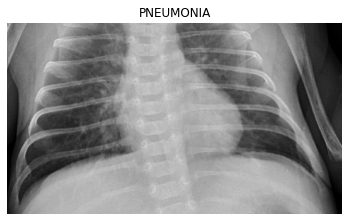

In [5]:
# Viewing a random image from train
img = view_random_image(target_dir="/content/chest_xray/train/",
                        target_class="PNEUMONIA")

['NORMAL2-IM-0499-0001.jpeg']
Image shape: (1106, 1414)
['person1544_virus_2685.jpeg']
Image shape: (1152, 1720)


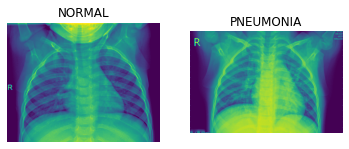

In [6]:
# Visualize both the data 
plt.figure()
plt.subplot(1, 2, 1)
normal = view_random_image("/content/chest_xray/train/", "NORMAL")
plt.subplot(1, 2, 2)
pneumonia = view_random_image("/content/chest_xray/train/", "PNEUMONIA")

In [7]:
# setup data inputs
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/chest_xray/train/"
test_dir = "/content/chest_xray/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Train images :")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")

print("Testing images :")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="binary")

Train images :
Found 5232 images belonging to 2 classes.
Testing images :
Found 624 images belonging to 2 classes.


## 2. Preprocessing the data 

The data presented to us is not same, some images are of random shapes and also let's Normalize our data so that it becomes easier for our Neural Network to learn patterns.

In [8]:
# Defining directory dataset paths
train_dir = "/content/chest_xray/train/"
test_dir = "/content/chest_xray/test/"

In [9]:
# Normalization 
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=32,
                                             target_size=(224, 224),
                                             class_mode="binary",
                                             seed=42)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
# Getting a sample of a train data batch
images, labels = train_data.next()  
len(images), len(labels)

(32, 32)

## 3. Creating our models

We are using a CNNs (Convolutional Neural Networks) to get quick results on our model than a normal ANN (Artificial Neural Network)

### 1. Model 1

For this model we will be using a Conv2D layer then a MaxPool2D then Conv2D layer and then a MaxPool2D layer followed by a Flatten and output layer.

*All the models are trained and saved in the drive, so they need not to be run again.*

In [12]:
# Build a CNN model 
model_1 = tf.keras.models.Sequential([
     tf.keras.layers.Conv2D(filters=10,
                            kernel_size=3,
                            activation="relu",

                            input_shape=(224, 224, 3)),
     tf.keras.layers.MaxPool2D(pool_size=2,

                               padding="valid"),
     tf.keras.layers.Conv2D(10, 3, activation="relu"),
     tf.keras.layers.MaxPool2D(2),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(1, activation="sigmoid")
])

In [13]:
# Compiling the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [14]:
# seed  
tf.random.set_seed(42)

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
164/164 [==============================] - 57s 333ms/step - loss: 0.2636 - accuracy: 0.8916 - val_loss: 0.6695 - val_accuracy: 0.7660
Epoch 2/5
164/164 [==============================] - 55s 334ms/step - loss: 0.1037 - accuracy: 0.9620 - val_loss: 1.1092 - val_accuracy: 0.7083
Epoch 3/5
164/164 [==============================] - 54s 331ms/step - loss: 0.0812 - accuracy: 0.9706 - val_loss: 1.0952 - val_accuracy: 0.7308
Epoch 4/5
164/164 [==============================] - 54s 329ms/step - loss: 0.0724 - accuracy: 0.9725 - val_loss: 1.1619 - val_accuracy: 0.7083
Epoch 5/5
164/164 [==============================] - 54s 330ms/step - loss: 0.0641 - accuracy: 0.9765 - val_loss: 1.2843 - val_accuracy: 0.7404


### 2. Model 2

For this model we will be using a Conv2D layer, then a Conv2D layer, then a MaxPool2D layer, then Conv2D layer, then Conv2D layer and then a MaxPool2D layer followed by a Flatten and output layer.

*All the models are trained and saved in the drive, so they need not to be run again.*

In [15]:
# Build a CNN model (Tiny VGG)
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [16]:
# Compiling the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [17]:
# seed  
tf.random.set_seed(42)

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
164/164 [==============================] - 56s 335ms/step - loss: 0.2833 - accuracy: 0.8784 - val_loss: 0.8508 - val_accuracy: 0.7388
Epoch 2/5
164/164 [==============================] - 55s 337ms/step - loss: 0.1116 - accuracy: 0.9574 - val_loss: 0.8087 - val_accuracy: 0.7548
Epoch 3/5
164/164 [==============================] - 55s 338ms/step - loss: 0.0808 - accuracy: 0.9704 - val_loss: 1.4602 - val_accuracy: 0.7179
Epoch 4/5
164/164 [==============================] - 55s 337ms/step - loss: 0.0694 - accuracy: 0.9755 - val_loss: 1.2673 - val_accuracy: 0.7276
Epoch 5/5
164/164 [==============================] - 55s 337ms/step - loss: 0.0591 - accuracy: 0.9786 - val_loss: 0.9741 - val_accuracy: 0.7404


### 3. Model 3

For this model we will be using a Conv2D layer, then a Conv2D layer, then a MaxPool2D layer, then Conv2D layer, then Conv2D layer and then a MaxPool2D layer followed by a Flatten and output layer. But the `Adam()`'s learning rate set to `0.01`.

*All the models are trained and saved in the drive, so they need not to be run again.*

In [18]:
# Build a CNN model 
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [19]:
# Compiling the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

In [20]:
# seed  
tf.random.set_seed(42)

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
164/164 [==============================] - 57s 345ms/step - loss: 0.6301 - accuracy: 0.7380 - val_loss: 0.6752 - val_accuracy: 0.6250
Epoch 2/5
164/164 [==============================] - 55s 338ms/step - loss: 0.5714 - accuracy: 0.7422 - val_loss: 0.6929 - val_accuracy: 0.6250
Epoch 3/5
164/164 [==============================] - 56s 341ms/step - loss: 0.5710 - accuracy: 0.7422 - val_loss: 0.6923 - val_accuracy: 0.6250
Epoch 4/5
164/164 [==============================] - 55s 338ms/step - loss: 0.5710 - accuracy: 0.7422 - val_loss: 0.6956 - val_accuracy: 0.6250
Epoch 5/5
164/164 [==============================] - 55s 337ms/step - loss: 0.5711 - accuracy: 0.7422 - val_loss: 0.6947 - val_accuracy: 0.6250


### 4. Model 4

For this model we will be using a Conv2D layer, then a Conv2D layer, then a MaxPool2D layer, then Conv2D layer, then Conv2D layer and then a MaxPool2D layer followed by a Flatten and output layer.

*All the models are trained and saved in the drive, so they need not to be run again.*

In [21]:
# Build a CNN model 
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [22]:
# Compiling the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

In [23]:
# seed  
tf.random.set_seed(42)

# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
164/164 [==============================] - 54s 329ms/step - loss: 0.4707 - accuracy: 0.8255 - val_loss: 0.5976 - val_accuracy: 0.7372
Epoch 2/5
164/164 [==============================] - 54s 329ms/step - loss: 0.3321 - accuracy: 0.8588 - val_loss: 0.8164 - val_accuracy: 0.7147
Epoch 3/5
164/164 [==============================] - 54s 331ms/step - loss: 0.3356 - accuracy: 0.8723 - val_loss: 0.6058 - val_accuracy: 0.6458
Epoch 4/5
164/164 [==============================] - 54s 331ms/step - loss: 0.3458 - accuracy: 0.8389 - val_loss: 0.8490 - val_accuracy: 0.6715
Epoch 5/5
164/164 [==============================] - 55s 334ms/step - loss: 0.2925 - accuracy: 0.8624 - val_loss: 0.9363 - val_accuracy: 0.7051


### Model 5

In [24]:
# Build a CNN model 
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16,
                           kernel_size=3,
                           activation="relu",
                           padding="same",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
    tf.keras.layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    tf.keras.layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(rate=0.7),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [25]:
# Compiling the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [26]:
# seed  
tf.random.set_seed(42)

# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
164/164 [==============================] - 63s 374ms/step - loss: 0.5894 - accuracy: 0.7383 - val_loss: 0.6792 - val_accuracy: 0.6250
Epoch 2/5
164/164 [==============================] - 61s 369ms/step - loss: 0.5825 - accuracy: 0.7422 - val_loss: 0.6836 - val_accuracy: 0.6250
Epoch 3/5
164/164 [==============================] - 60s 365ms/step - loss: 0.5773 - accuracy: 0.7422 - val_loss: 0.6863 - val_accuracy: 0.6250
Epoch 4/5
164/164 [==============================] - 59s 361ms/step - loss: 0.5745 - accuracy: 0.7422 - val_loss: 0.6916 - val_accuracy: 0.6250
Epoch 5/5
164/164 [==============================] - 59s 361ms/step - loss: 0.5741 - accuracy: 0.7422 - val_loss: 0.6920 - val_accuracy: 0.6250


### Model 6

In [27]:
# Build a CNN model 
model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16,
                           kernel_size=3,
                           activation="relu",
                           padding="same",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
    tf.keras.layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    tf.keras.layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(rate=0.7),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [28]:
# Compiling the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [29]:
# seed  
tf.random.set_seed(42)

# Fit the model
history_6 = model_6.fit_generator(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
164/164 [==============================] - 62s 369ms/step - loss: 0.5915 - accuracy: 0.7397 - val_loss: 0.6624 - val_accuracy: 0.6250
Epoch 2/5
164/164 [==============================] - 60s 364ms/step - loss: 0.5794 - accuracy: 0.7422 - val_loss: 0.7069 - val_accuracy: 0.6250
Epoch 3/5
164/164 [==============================] - 60s 363ms/step - loss: 0.5748 - accuracy: 0.7422 - val_loss: 0.6861 - val_accuracy: 0.6250
Epoch 4/5
164/164 [==============================] - 60s 368ms/step - loss: 0.5741 - accuracy: 0.7422 - val_loss: 0.6876 - val_accuracy: 0.6250
Epoch 5/5
164/164 [==============================] - 60s 366ms/step - loss: 0.5737 - accuracy: 0.7422 - val_loss: 0.6896 - val_accuracy: 0.6250


## Transfer learnt Models

In [30]:
# Models from tensorflow_hub
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1"
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
efficientnetb1_url = "https://tfhub.dev/tensorflow/efficientnet/b1/classification/1"

In [31]:
# Create a model function to create a model from url
def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow Hub url and creates a Keras Sequential model with it.

  Args:
    model_url (str) : A tensorflow hub feature extraction URL.
    num_classes (int) : Number of output neurons in the output layers.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons. 
  """
  
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=True, # freezing already learnt patterns 
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(None,))
  # Create our own model 
  model = tf.keras.Sequential([
     feature_extractor_layer,
     layers.Dense(1, activation="sigmoid", name="output_layer")                          
  ])
  
  return model

In [32]:
# To get rid of 3 byte image not processed error
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Resnet Model

In [33]:
resnet_model = create_model(resnet_url)

In [34]:
# Compiling our model
resnet_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [35]:
tf.random.set_seed(42)

# Fitting our model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data = test_data,
                                  validation_steps = len(test_data))

Epoch 1/5
164/164 [==============================] - 79s 431ms/step - loss: 0.5376 - accuracy: 0.9444 - val_loss: 22.4366 - val_accuracy: 0.7516
Epoch 2/5
164/164 [==============================] - 69s 418ms/step - loss: 0.4848 - accuracy: 0.9599 - val_loss: 11173.5703 - val_accuracy: 0.6250
Epoch 3/5
164/164 [==============================] - 69s 418ms/step - loss: 0.4547 - accuracy: 0.9578 - val_loss: 1.1458 - val_accuracy: 0.8061
Epoch 4/5
164/164 [==============================] - 68s 414ms/step - loss: 0.3888 - accuracy: 0.9732 - val_loss: 0.8116 - val_accuracy: 0.8622
Epoch 5/5
164/164 [==============================] - 68s 413ms/step - loss: 0.3506 - accuracy: 0.9784 - val_loss: 2.5211 - val_accuracy: 0.6442


### Efficientnet

In [36]:
efficientnet_model = create_model(efficientnet_url)

In [37]:
# Compiling our model
efficientnet_model.compile(loss="binary_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [38]:
tf.random.set_seed(42)

# Fitting our model
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data = test_data,
                                              validation_steps = len(test_data))

Epoch 1/5
164/164 [==============================] - 85s 427ms/step - loss: 0.7477 - accuracy: 0.9155 - val_loss: 0.7463 - val_accuracy: 0.7324
Epoch 2/5
164/164 [==============================] - 68s 414ms/step - loss: 0.6274 - accuracy: 0.9316 - val_loss: 0.6419 - val_accuracy: 0.8622
Epoch 3/5
164/164 [==============================] - 69s 416ms/step - loss: 0.5497 - accuracy: 0.9415 - val_loss: 0.6187 - val_accuracy: 0.8429
Epoch 4/5
164/164 [==============================] - 68s 415ms/step - loss: 0.4857 - accuracy: 0.9581 - val_loss: 0.5894 - val_accuracy: 0.8381
Epoch 5/5
164/164 [==============================] - 68s 414ms/step - loss: 0.4430 - accuracy: 0.9532 - val_loss: 0.8052 - val_accuracy: 0.6250


### Mobilenet

In [39]:
mobilenet_model = create_model(mobilenet_url)

In [40]:
# Compiling our model
mobilenet_model.compile(loss="binary_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [41]:
tf.random.set_seed(42)

# Fitting our model
mobilenet_history = mobilenet_model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data = test_data,
                                        validation_steps = len(test_data))

Epoch 1/5
164/164 [==============================] - 70s 393ms/step - loss: 0.2706 - accuracy: 0.9601 - val_loss: 4.3178 - val_accuracy: 0.6843
Epoch 2/5
164/164 [==============================] - 63s 383ms/step - loss: 0.1747 - accuracy: 0.9824 - val_loss: 2.3074 - val_accuracy: 0.7869
Epoch 3/5
164/164 [==============================] - 63s 383ms/step - loss: 0.1802 - accuracy: 0.9822 - val_loss: 2.2148 - val_accuracy: 0.7420
Epoch 4/5
164/164 [==============================] - 63s 383ms/step - loss: 0.1638 - accuracy: 0.9860 - val_loss: 1.5404 - val_accuracy: 0.7612
Epoch 5/5
164/164 [==============================] - 63s 382ms/step - loss: 0.1489 - accuracy: 0.9876 - val_loss: 1.1626 - val_accuracy: 0.8253


### Efficientnetb1

In [42]:
efficientnetb1_model = create_model(efficientnetb1_url)

In [43]:
# Compiling our model
efficientnetb1_model.compile(loss="binary_crossentropy",
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=["accuracy"])

In [44]:
tf.random.set_seed(42)

# Fitting our model
efficientnetb1_history = efficientnetb1_model.fit(train_data,
                                                  epochs=5,
                                                  steps_per_epoch=len(train_data),
                                                  validation_data = test_data,
                                                  validation_steps = len(test_data))

Epoch 1/5
164/164 [==============================] - 98s 482ms/step - loss: 0.7569 - accuracy: 0.9134 - val_loss: 0.7246 - val_accuracy: 0.8205
Epoch 2/5
164/164 [==============================] - 78s 472ms/step - loss: 0.6545 - accuracy: 0.8666 - val_loss: 0.7459 - val_accuracy: 0.6827
Epoch 3/5
164/164 [==============================] - 78s 473ms/step - loss: 0.5771 - accuracy: 0.9083 - val_loss: 0.7386 - val_accuracy: 0.5513
Epoch 4/5
164/164 [==============================] - 78s 473ms/step - loss: 0.5068 - accuracy: 0.9450 - val_loss: 0.7137 - val_accuracy: 0.7083
Epoch 5/5
164/164 [==============================] - 78s 473ms/step - loss: 0.4448 - accuracy: 0.9641 - val_loss: 0.5430 - val_accuracy: 0.8654


## Visualizing loss and accuracy curves for all the models

In [45]:
# Plotting the valildation and training curves seperately
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss 
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

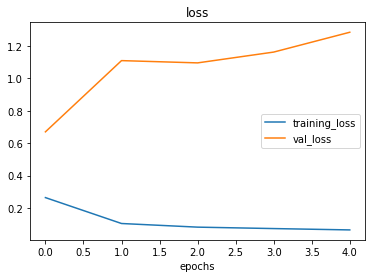

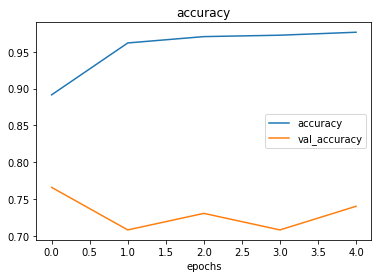

In [46]:
plot_loss_curves(history_1)

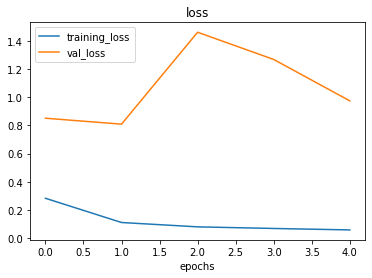

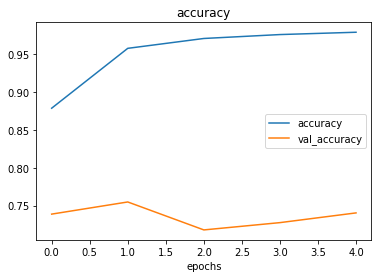

In [47]:
plot_loss_curves(history_2)

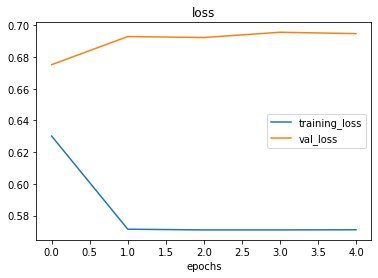

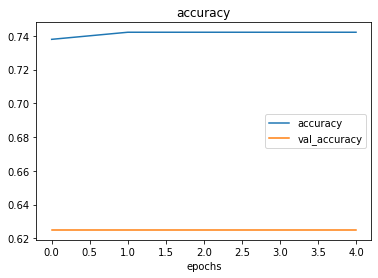

In [48]:
plot_loss_curves(history_3)

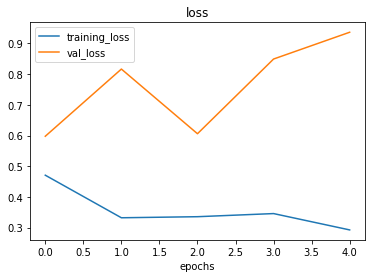

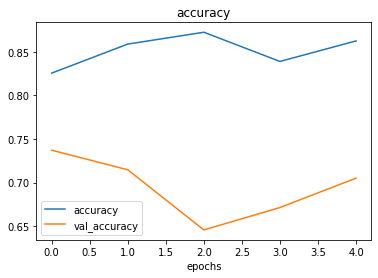

In [49]:
plot_loss_curves(history_4)

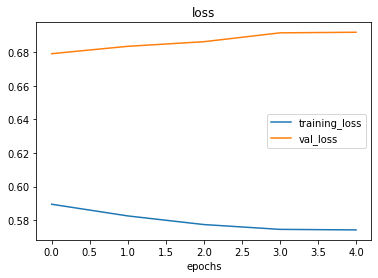

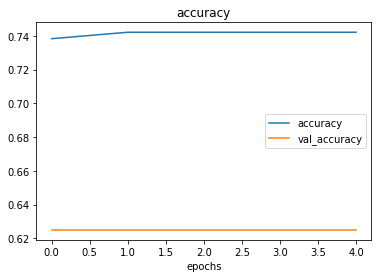

In [50]:
plot_loss_curves(history_5)

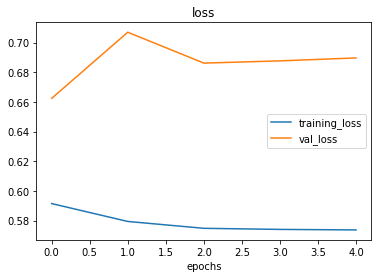

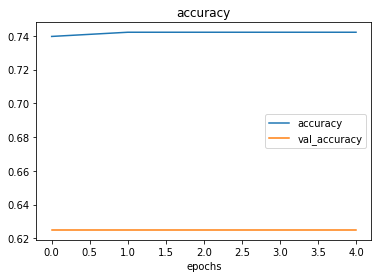

In [51]:
plot_loss_curves(history_6)

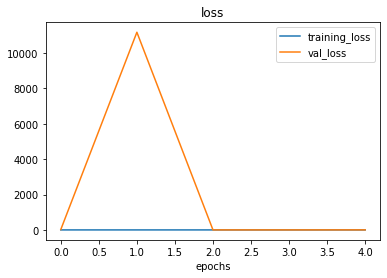

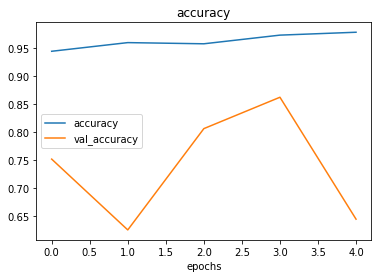

In [52]:
plot_loss_curves(resnet_history)

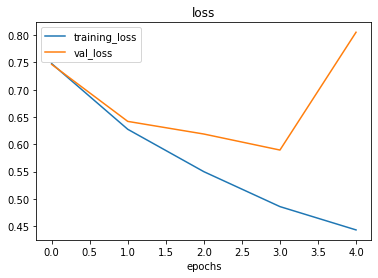

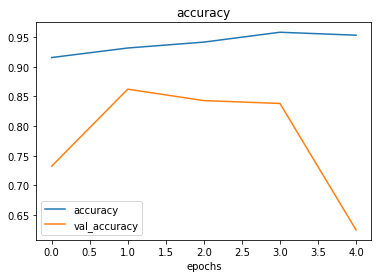

In [53]:
plot_loss_curves(efficientnet_history)

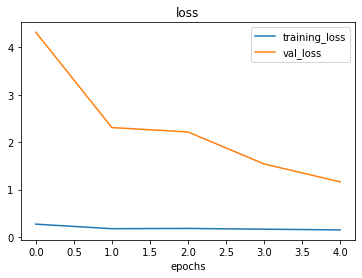

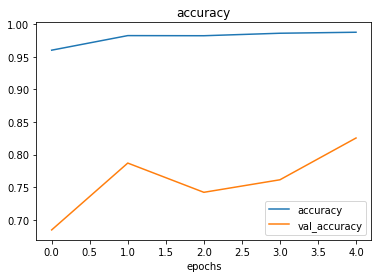

In [54]:
plot_loss_curves(mobilenet_history)

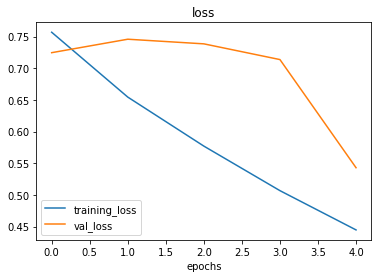

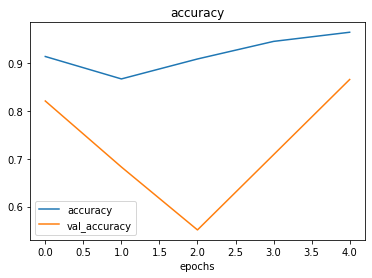

In [55]:
plot_loss_curves(efficientnetb1_history)

## Evaluating accuracy for all the models

In [56]:
model_1.evaluate(test_data)

20/20 [==============================] - 5s 254ms/step - loss: 1.2843 - accuracy: 0.7404


[1.284301996231079, 0.7403846383094788]

In [57]:
model_2.evaluate(test_data)

20/20 [==============================] - 5s 252ms/step - loss: 0.9741 - accuracy: 0.7404


[0.9740813970565796, 0.7403846383094788]

In [58]:
model_3.evaluate(test_data)

20/20 [==============================] - 5s 255ms/step - loss: 0.6947 - accuracy: 0.6250


[0.6947331428527832, 0.625]

In [59]:
model_4.evaluate(test_data)

20/20 [==============================] - 5s 251ms/step - loss: 0.9363 - accuracy: 0.7051


[0.9362515211105347, 0.7051281929016113]

In [60]:
model_5.evaluate(test_data)

20/20 [==============================] - 5s 257ms/step - loss: 0.6920 - accuracy: 0.6250


[0.6919654011726379, 0.625]

In [61]:
model_6.evaluate(test_data)

20/20 [==============================] - 5s 256ms/step - loss: 0.6896 - accuracy: 0.6250


[0.689606785774231, 0.625]

In [62]:
resnet_model.evaluate(test_data)

20/20 [==============================] - 6s 274ms/step - loss: 2.5211 - accuracy: 0.6442


[2.521135091781616, 0.6442307829856873]

In [63]:
efficientnet_model.evaluate(test_data)

20/20 [==============================] - 6s 271ms/step - loss: 0.8052 - accuracy: 0.6250


[0.8052102327346802, 0.625]

In [64]:
mobilenet_model.evaluate(test_data)

20/20 [==============================] - 6s 265ms/step - loss: 1.1626 - accuracy: 0.8253


[1.1626386642456055, 0.8253205418586731]

In [65]:
efficientnetb1_model.evaluate(test_data)

20/20 [==============================] - 6s 275ms/step - loss: 0.5430 - accuracy: 0.8654


[0.5430172085762024, 0.8653846383094788]

## Conclusions 

With all the model building, testing and tuning we come to the conclusion that our `efficientnetb1_model` is the best with `90%` accuracyon test data.

![Image](https://i.ibb.co/cCBsJ8P/accuracy.jpg)

In [66]:
# Custom layer for our pre-trained model
feature_extractor_layer = hub.KerasLayer(efficientnetb1_url,
                                         trainable=True, # freezing already learnt patterns 
                                         name="feature_extraction_layer",
                                         input_shape=IMAGE_SHAPE+(None,))

In [67]:
Xray_model = tf.keras.models.load_model("/content/drive/MyDrive/efficientnetb1_model.h5", custom_objects={'KerasLayer': feature_extractor_layer})

In [68]:
Xray_model.evaluate(test_data)

20/20 [==============================] - 8s 277ms/step - loss: 0.5227 - accuracy: 0.9022


[0.5226752758026123, 0.9022436141967773]

In [69]:
Xray_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1000)              7856232   
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1001      
Total params: 7,857,233
Trainable params: 7,795,185
Non-trainable params: 62,048
_________________________________________________________________


## Predictions on custom data

In [70]:
# function to import image and resize 
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape,, color_channels)
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image  
  img = tf.image.resize(img, size=IMAGE_SHAPE)
  #Grayscale
  img = tf.image.grayscale_to_rgb(img)
  # Rescale the image (getting all values between 0 & 1)
  img = img/255

  return img

In [71]:
def pred_and_plot(model, filename, class_names=["NORMAL","PNEUMONIA"]):
  """
  Imports an image located at filename, makes a prediction with model and plots the image with the predicted class as the title.
  """
  # Import target image and preprocess it 
  img = load_and_prep_image(filename)

  # Make a prediction 
  pred = model.predict(tf.expand_dims(img, axis=0))
  # pred = model.predict(tf.squeeze(img))

  # Get the predicted class 
  pred_class = class_names[int(tf.round(pred))]

  # Plot image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction : {pred_class}")
  plt.axis(False);

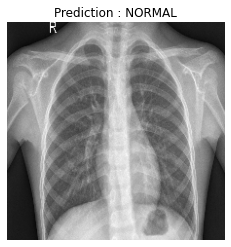

In [72]:
pred_and_plot(Xray_model,"/content/norm1.jpeg" )

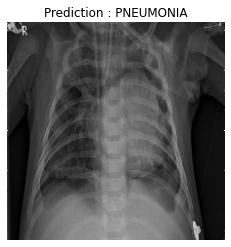

In [73]:
pred_and_plot(Xray_model,"/content/pneu1.jpeg" )

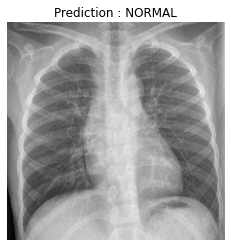

In [74]:
pred_and_plot(Xray_model,"/content/norm2.jpeg" )

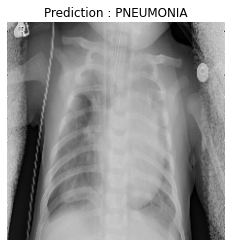

In [75]:
pred_and_plot(Xray_model,"/content/pneu2.jpeg" )